# A jupyter notebook to transform Galaxy history into an RDF provenance graph using the PROV-O ontology

see also: https://usegalaxy.fr/api/docs 


In [2]:
from rdflib import Dataset, URIRef, Literal, BNode
import requests
import json
from tqdm.notebook import tqdm

from IPython.display import display, Markdown

from rdflib import Namespace
from rdflib.namespace import DCTERMS, OWL, RDF, RDFS, XMLNS, XSD

from datetime import datetime

PROV = Namespace("http://www.w3.org/ns/prov#")

# YOUR API KEY
# api_key = "a0184a05326258ba222783c6fb2949c4"
# galaxy_url = "https://usegalaxy.fr"

api_key = "b15041ec63cd53ad3e02f25cc3fa6781"
galaxy_url = "https://usegalaxy.eu"

http_params = {"key": api_key}
galaxy_hist_url = galaxy_url + "/api/histories"

In [64]:
def list_public_histories(url, key):
    """ """
    res = []
    r = requests.get(url + "/api/histories/published", params={"key": str(key)})
    print(r.text)
    print(r.json())
    histories = r.json()
    # if r.json().get('err_msg'):
    #    print(r.json()['err_msg'])
    #    return res

    for h in histories:
        if "2025-" in h["update_time"]:
            res.append((h["id"], h["name"], h["update_time"]))

    res = sorted(
        res,
        key=lambda x: datetime.fromisoformat(x[2].replace("Z", "+00:00")),
        reverse=True,
    )
    return res


def list_histories(url, key):
    """ """
    res = []
    r = requests.get(url + "/api/histories", params={"key": str(key)})
    print(r.text)
    print(r.json())
    histories = r.json()
    # if r.json().get('err_msg'):
    #    print(r.json()['err_msg'])
    #    return res

    for h in histories:
        res.append((h["id"], h["name"], h["update_time"]))

    res = sorted(
        res,
        key=lambda x: datetime.fromisoformat(x[2].replace("Z", "+00:00")),
        reverse=True,
    )
    return res


def print_histories(url, key):
    """ """
    histories = list_public_histories(url, key)
    md = """
| ID | NAME | UPDATE TIME |
| ------ | ------ | ------ |
"""
    for h in histories:
        md += "| " + h[0] + " | " + h[1] + " | " + h[2] + " |\n"

    display(Markdown(md))


def fetch_EDAM_formats_mapping(url, key):
    r = requests.get(url + "/api/datatypes/edam_formats", params={"key": str(key)})
    return r.json()


def fetch_EDAM_data_mapping(url, key):
    r = requests.get(url + "/api/datatypes/edam_data", params={"key": str(key)})
    return r.json()

In [79]:
edam_formats = fetch_EDAM_formats_mapping(url=galaxy_url, key=api_key)
print(f"Fetched {len(edam_formats)} EDAM formats mappings")
print(json.dumps(edam_formats, indent=2))

edam_data = fetch_EDAM_data_mapping(url=galaxy_url, key=api_key)
print(f"Fetched {len(edam_data)} EDAM data mappings")
print(json.dumps(edam_data, indent=2))

Fetched 755 EDAM formats mappings
{
  "source.h": "format_2330",
  "source.c": "format_2330",
  "source.cpp": "format_2330",
  "source.py": "format_2330",
  "source.go": "format_2330",
  "source.rs": "format_2330",
  "source.cs": "format_2330",
  "markdown": "format_2330",
  "hep.root": "format_2333",
  "jp2": "format_2333",
  "ab1": "format_3000",
  "afg": "format_3582",
  "agp": "format_3693",
  "anvio_cog_profile": "format_2331",
  "anvio_composite": "format_2331",
  "anvio_classifier": "format_1915",
  "anvio_contigs_db": "format_2331",
  "anvio_db": "format_2331",
  "anvio_genomes_db": "format_2331",
  "anvio_pan_db": "format_2331",
  "anvio_pfam_profile": "format_2331",
  "anvio_profile_db": "format_2331",
  "anvio_samples_db": "format_2331",
  "anvio_state": "format_3464",
  "anvio_structure_db": "format_2331",
  "anvio_variability": "format_3475",
  "arb": "format_2333",
  "arb.gz": "format_2333",
  "arff": "format_3581",
  "paf": "format_2330",
  "paf.gz": "format_2330",
  "gf

In [93]:
def gen_prov_graph_v2(url, key, hist_id):
    """ """
    G = Dataset()

    content_url = url + "/api/histories/" + hist_id + "/contents"

    # get the content of the history
    r = requests.get(content_url, params={"key": str(key)})
    content = r.json()

    for c in tqdm(content):
        content_id = c["id"]

        # get provenance from each history cell
        # print(f"requesting content {content_id} provenance")
        r = requests.get(
            content_url + "/" + content_id + "/provenance",
            params={"key": str(key)},
        )
        try:
            activity = r.json()
        except:
            print("No provenance available")
            print(r.text)
            continue
        activity = r.json()
        job_id = activity["job_id"]
        tool_id = activity["tool_id"].strip(" ")
        params = activity["parameters"]

        ############
        # generating the activity
        G.add((URIRef(job_id), RDF.type, PROV.Activity))
        G.add((URIRef(job_id), PROV.wasAssociatedWith, Literal(tool_id)))

        r = requests.get(url + "/api/jobs/" + job_id, params={"key": str(key)})
        job = r.json()
        if job.get("command_line"):
            # print(json.dumps(job, indent=True))
            print(job["command_line"])
            G.add((
                URIRef(job_id),
                PROV.value,
                Literal(job["command_line"]),
            ))
        G.add((
            URIRef(job_id),
            PROV.startedAtTime,
            Literal(job["create_time"], datatype=XSD.dateTime),
        ))
        G.add((
            URIRef(job_id),
            PROV.endedAtTime,
            Literal(job["update_time"], datatype=XSD.dateTime),
        ))

        ############
        # generating the output
        G.add((URIRef(content_id), RDF.type, PROV.Entity))
        G.add((URIRef(content_id), PROV.wasGeneratedBy, URIRef(job_id)))
        G.add((URIRef(content_id), PROV.wasAttributedTo, Literal(tool_id)))

        if c.get("name"):
            G.add((URIRef(content_id), RDFS.label, Literal(c["name"])))
        if c.get("url"):
            G.add((URIRef(content_id), RDFS.label, Literal(c["url"])))
        if c.get("dataset_id"):
            d_id = c.get("dataset_id")
            r2 = requests.get(url + "/api/datasets/" + d_id, params={"key": str(key)})
            dataset = r2.json()
            # print()
            # print(json.dumps(dataset, indent=True))
            # print()

        ############
        # generating the inputs
        for k in tqdm(params.keys()):
            if "input" in k:
                if isinstance(params[k], dict) and params[k].get("id"):
                    input_id = params[k]["id"]
                    r = requests.get(
                        url + "/api/datasets/" + input_id,
                        params={"key": str(key)},
                    )
                    in_dataset = r.json()
                    print(json.dumps(in_dataset, indent=True))

                    G.add((URIRef(input_id), RDF.type, PROV.Entity))
                    if in_dataset.get("name"):
                        G.add((
                            URIRef(input_id),
                            RDFS.label,
                            Literal(in_dataset["name"]),
                        ))
                    if in_dataset.get("url"):
                        G.add((
                            URIRef(input_id),
                            RDFS.label,
                            Literal(in_dataset["download_url"]),
                        ))

                    # adding EDAM format & data
                    if in_dataset.get("extension"):
                        file_ext = in_dataset["extension"]
                        print("extension:", in_dataset["extension"])
                        if file_ext in edam_formats.keys():
                            edam_format_value = edam_formats[file_ext]
                            G.add((
                                URIRef(input_id),
                                URIRef("http://edamontology.org/has_format"),
                                URIRef(f"http://edamontology.org/{edam_format_value}"),
                            ))
                        else:
                            print(f"No EDAM format mapping for extension: {file_ext}")

                        if file_ext in edam_data.keys():
                            edam_data_value = edam_data[file_ext]
                            G.add((
                                URIRef(input_id),
                                URIRef("http://edamontology.org/has_data"),
                                URIRef(f"http://edamontology.org/{edam_data_value}"),
                            ))
                        else:
                            print(f"No EDAM data mapping for extension: {file_ext}")

                    G.add((URIRef(job_id), PROV.used, URIRef(input_id)))
                    G.add((
                        URIRef(content_id),
                        PROV.wasDerivedFrom,
                        URIRef(input_id),
                    ))
    return G

In [94]:
# %%time
# print_histories(galaxy_url, api_key)

In [95]:
%%time
# graph = gen_prov_graph_v2(galaxy_url, api_key, "50b6ae34a811c9ba")
graph = gen_prov_graph_v2(galaxy_url, api_key, "11ac94870d0bb33a76b5f0b7b347b500")

  0%|          | 0/124 [00:00<?, ?it/s]

python '/opt/galaxy/server/lib/galaxy/tools/data_fetch.py' --galaxy-root '/opt/galaxy/server' --datatypes-registry '/data/jwd08/main/093/955/93955361/registry.xml' --request-version '1' --request '/data/jwd08/main/093/955/93955361/configs/tmp58y8czf0'


  0%|          | 0/5 [00:00<?, ?it/s]

No provenance available
<html>
  <head><title>Internal Server Error</title></head>
  <body>
    <h1>Internal Server Error</h1>
    <p>The server has either erred or is incapable of performing
the requested operation.

<br/>
<!--  --></p>
    <hr noshade>
    <div align="right">WSGI Server</div>
  </body>
</html>

No provenance available
<html>
  <head><title>Internal Server Error</title></head>
  <body>
    <h1>Internal Server Error</h1>
    <p>The server has either erred or is incapable of performing
the requested operation.

<br/>
<!--  --></p>
    <hr noshade>
    <div align="right">WSGI Server</div>
  </body>
</html>

No provenance available
<html>
  <head><title>Internal Server Error</title></head>
  <body>
    <h1>Internal Server Error</h1>
    <p>The server has either erred or is incapable of performing
the requested operation.

<br/>
<!--  --></p>
    <hr noshade>
    <div align="right">WSGI Server</div>
  </body>
</html>

set -o | grep -q pipefail && set -o pipefail;  mkdir -p

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "resubmitted": false,
 "create_time": "2025-12-08T14:26:01.375184",
 "visible": true,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "uploaded txt file",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.data.Text",
 "rerunnable": false,
 "purged": false,
 "extension": "txt",
 "state": "ok",
 "update_time": "2025-12-08T14:29:36.891506",
 "display_types": [],
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce/display",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "datase

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "txt",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "extension": "txt",
 "file_size": 66,
 "purged": false,
 "misc_info": "uploaded txt file",
 "data_type": "galaxy.datatypes.data.Text",
 "accessible": true,
 "rerunnable": false,
 "name": "SRR_Acc_List.txt",
 "hid": 1,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac84b963edb807657ce",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "file_name": "/data/dnb12/galaxy_db/files/d/9/2/dataset_d92c079e-be94-4444-b977-04bb90c28cbf.dat",
 "visible": true,
 "misc_bl

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac84b963edb807657ce",
 "drs_id": "hda-3d48debf8e1cd5d2c14eed8da91f1038",
 "hashes": [
  {
   "model_class": "DatasetHash",
   "id": 1754866,
   "hash_function": "SHA-256",
   "hash_value": "9a19c29fdbcde0df42de8c1670c06d061aef3848b7e40153c6f4ec2a54897f8c",
   "extra_files_path": null
  }
 ],
 "sources": [],
 "misc_blurb": "6 lines",
 "name": "SRR_Acc_List.txt",
 "data_type": "galaxy.datatypes.data.Text",
 "file_size": 66,
 "display_apps": [],
 "display_types": [],
 "visible": true,
 "meta_files": [],
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",


  0%|          | 0/6 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "resubmitted": false,
 "create_time": "2025-12-08T14:26:01.375184",
 "visible": true,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "uploaded txt file",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.data.Text",
 "rerunnable": false,
 "purged": false,
 "extension": "txt",
 "state": "ok",
 "update_time": "2025-12-08T14:29:36.891506",
 "display_types": [],
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce/display",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "datase

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "misc_blurb": "6 lines",
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "resubmitted": false,
 "name": "SRR_Acc_List.txt",
 "update_time": "2025-12-08T14:29:36.891506",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "uploaded txt file",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d8676538529fa9e6129884",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "rerunnable": false,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "type_id": "dataset-26c75dcccb616ac84b963edb807657ce",
 "drs_id": "hda-3d48debf8e1cd5d2c14eed8da91f1038",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "data_type": "galaxy.datatypes.data.Text",
 "hashes": [
  {
   "model_class": "DatasetH

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "misc_blurb": "6 lines",
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "resubmitted": false,
 "name": "SRR_Acc_List.txt",
 "update_time": "2025-12-08T14:29:36.891506",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "uploaded txt file",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d8676538529fa9e6129884",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "rerunnable": false,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "type_id": "dataset-26c75dcccb616ac84b963edb807657ce",
 "drs_id": "hda-3d48debf8e1cd5d2c14eed8da91f1038",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "data_type": "galaxy.datatypes.data.Text",
 "hashes": [
  {
   "model_class": "DatasetH

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "misc_blurb": "6 lines",
 "uuid": "d92c079e-be94-4444-b977-04bb90c28cbf",
 "resubmitted": false,
 "name": "SRR_Acc_List.txt",
 "update_time": "2025-12-08T14:29:36.891506",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "uploaded txt file",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d8676538529fa9e6129884",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac84b963edb807657ce",
 "rerunnable": false,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>SRR1923679</td></tr><tr><td>SRR1923680</td></tr><tr><td>SRR1923681</td></tr><tr><td>SRR1923668</td></tr><tr><td>SRR1923669</td></tr></table>",
 "type_id": "dataset-26c75dcccb616ac84b963edb807657ce",
 "drs_id": "hda-3d48debf8e1cd5d2c14eed8da91f1038",
 "id": "26c75dcccb616ac84b963edb807657ce",
 "data_type": "galaxy.datatypes.data.Text",
 "hashes": [
  {
   "model_class": "DatasetH

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "fastqsanger.gz",
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9CBFH@EDGBD;;9??D*?*:)?8)??8DF49=\n@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:2072:2157/1\n",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac879af659f2335ff35",
 "extension": "fastqsanger.gz",
 "file_size": 1835763351,
 "purged": false,
 "misc_info": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "accessible": true,
 "rerunnable": true,
 "name": "SRR1923667",
 "hid": 6,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac879af659f2335ff35",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "file_name": "/data/dnb12/galaxy_db/files/6/e/5/dataset_6e5f1d06-c343-4b79-b4

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "misc_blurb": "1.7 GB",
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "resubmitted": false,
 "name": "SRR1923667",
 "update_time": "2025-12-08T18:14:37.437106",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": null,
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867655ecd7e16af94a5a9",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac879af659f2335ff35",
 "rerunnable": true,
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9CBFH@EDGBD;;9??D*?*:)?8)??8DF49=\n@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:2072:2157/1\n",
 "type_id": "dataset-26c75dcccb616ac879af659f2335ff35",
 "drs_id": "hda-3d48debf8e1cd5d298c69303ae25782f",
 "id": "26c75dcccb616ac879af659f2335ff35",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "visible":

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac879af659f2335ff35",
 "create_time": "2025-12-08T18:14:37.437103",
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9CBFH@EDGBD;;9??D*?*:)?8)??8DF49=\n@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:2072:2157/1\n",
 "update_time": "2025-12-08T18:14:37.437106",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/6/e/5/dataset_6e5f1d06-c343-4b79-b471-76eb327c6395.dat",
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d867655ecd7e16af94a5a9",
 "name": "SRR1923667",
 "api_type": "file",
 "display_app

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "misc_blurb": "1.3 GB",
 "uuid": "5b8a0838-14a4-4b85-aa29-e56fc146885d",
 "resubmitted": false,
 "name": "SRR1923668",
 "update_time": "2025-12-08T18:14:37.437109",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": null,
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867654cd278177ddb629c",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893",
 "rerunnable": true,
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "type_id": "dataset-26c75dcccb616ac80c53aeed5afa2893",
 "drs_id": "hda-3d48debf8e1cd5d25e20e41403674a54",
 "id": "26c75dcccb616ac80c53aeed5afa2893",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "visible":

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a03a93f9ae7afe8b0",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 7,
 "accessible": true,
 "create_time": "2025-12-08T18:14:37.437108",
 "annotation": null,
 "extension": "fastqsanger.gz",
 "resubmitted": false,
 "file_size": 1418730190,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "1.3 GB",
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_ext": "fastqsanger.gz",
 "update_time": "2025-12-08T18:14:37.437109",
 "state": "ok",
 "name": "SRR1923668",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437109",
 "type": "file",
 "misc_blurb": "1.3 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/5/b/8/dataset_5b8a0838-14a4-4b85-aa29-e56fc146885d.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437108",
 "sources": [],
 "id": "26c75dcccb616ac80c53aeed5afa2893",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "5b8a0838-14a4-4b85-aa29-e56fc146885d",
 "dataset_id": "4838ba20a6d867654cd278177ddb629c",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a03a93f9ae7afe8b0",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 8,
 "accessible": true,
 "create_time": "2025-12-08T18:14:37.437111",
 "annotation": null,
 "extension": "fastqsanger.gz",
 "resubmitted": false,
 "file_size": 2154985348,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "2.0 GB",
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_ext": "fastqsanger.gz",
 "update_time": "2025-12-08T18:14:37.437112",
 "state": "ok",
 "name": "SRR1923669",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437112",
 "type": "file",
 "misc_blurb": "2.0 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/7/2/d/dataset_72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437111",
 "sources": [],
 "id": "26c75dcccb616ac892bf1426c6e5a4ea",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b",
 "dataset_id": "4838ba20a6d8676565f1efc883aa4e83",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHI

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac892bf1426c6e5a4ea",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac892bf1426c6e5a4ea",
 "drs_id": "hda-3d48debf8e1cd5d2e2382b2fd60cb2a8",
 "hashes": [],
 "sources": [],
 "misc_blurb": "2.0 GB",
 "name": "SRR1923669",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_size": 2154985348,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [],
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea/display",
 "state": "ok",
 "hid": 8,
 "tags": [],
 "cr

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a2a0c21763a17aae",
 "resubmitted": false,
 "create_time": "2025-12-08T18:14:37.437113",
 "visible": false,
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBEHCHHH?F>F4C<<DEFG@>DII<:?F?DCD>D\n@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1979:2046/1\n",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": null,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "rerunnable": true,
 "purged": false,
 "extension": "fastqsanger.gz",
 "state": "ok",
 "update_time": "2025-12-08T18:14:37.437114",
 "display_types": [],
 "uuid": "4c51efb1-a185-446f-84c5-6e0a5a54aaf9",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a2a0c21763a17aae/display",
 "id": "26c75d

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a2a0c21763a17aae",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac8a2a0c21763a17aae",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8a2a0c21763a17aae",
 "drs_id": "hda-3d48debf8e1cd5d200cb7a8dc27dc4bb",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.4 GB",
 "name": "SRR1923679",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_size": 1468294060,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [],
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBEHCHHH?F>F4C<<DEFG@>DII<:?F?DCD>D\n@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1979:2046/1\n",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a2a0c21763a17aae/display",
 "state": "ok",
 "hid": 9,
 "tags": [],
 "cr

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8a2a0c21763a17aae",
 "create_time": "2025-12-08T18:14:37.437113",
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBEHCHHH?F>F4C<<DEFG@>DII<:?F?DCD>D\n@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1979:2046/1\n",
 "update_time": "2025-12-08T18:14:37.437114",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/4/c/5/dataset_4c51efb1-a185-446f-84c5-6e0a5a54aaf9.dat",
 "uuid": "4c51efb1-a185-446f-84c5-6e0a5a54aaf9",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d8676552ab0ec56646426b",
 "name": "SRR1923679",
 "api_type": "file",
 "display_app

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "misc_blurb": "1.5 GB",
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "resubmitted": false,
 "name": "SRR1923680",
 "update_time": "2025-12-08T18:14:37.437116",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": null,
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867652eeb2e340727bc50",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac86843dea2af97020b",
 "rerunnable": true,
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "type_id": "dataset-26c75dcccb616ac86843dea2af97020b",
 "drs_id": "hda-3d48debf8e1cd5d25df6f5058ae35d6c",
 "id": "26c75dcccb616ac86843dea2af97020b",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "visible":

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437116",
 "type": "file",
 "misc_blurb": "1.5 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/a/9/5/dataset_a953f137-bc30-4c10-aef0-589ade4b05b9.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437115",
 "sources": [],
 "id": "26c75dcccb616ac86843dea2af97020b",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "dataset_id": "4838ba20a6d867652eeb2e340727bc50",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "fastqsanger.gz",
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac86843dea2af97020b",
 "extension": "fastqsanger.gz",
 "file_size": 1559528366,
 "purged": false,
 "misc_info": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "accessible": true,
 "rerunnable": true,
 "name": "SRR1923680",
 "hid": 10,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac86843dea2af97020b",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "file_name": "/data/dnb12/galaxy_db/files/a/9/5/dataset_a953f137-bc30-4c10-a

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "fastqsanger.gz",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHIJ3CEEHJDGJJJJJGGIGEGGHGAGHIIGGII\n@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1860:2088/1\n",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "extension": "fastqsanger.gz",
 "file_size": 1335952232,
 "purged": false,
 "misc_info": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "accessible": true,
 "rerunnable": true,
 "name": "SRR1923681",
 "hid": 11,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac8c9144171a4d36ea7",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "file_name": "/data/dnb12/galaxy_db/files/e/2/d/dataset_e2d1bce2-0795-410f-a

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "misc_blurb": "1.2 GB",
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "resubmitted": false,
 "name": "SRR1923681",
 "update_time": "2025-12-08T18:14:37.437118",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": null,
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d86765ffc616df24c0f050",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8c9144171a4d36ea7",
 "rerunnable": true,
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHIJ3CEEHJDGJJJJJGGIGEGGHGAGHIIGGII\n@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1860:2088/1\n",
 "type_id": "dataset-26c75dcccb616ac8c9144171a4d36ea7",
 "drs_id": "hda-3d48debf8e1cd5d2966427afad91436a",
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "visible":

  0%|          | 0/13 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a03a93f9ae7afe8b0",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 11,
 "accessible": true,
 "create_time": "2025-12-08T18:14:37.437118",
 "annotation": null,
 "extension": "fastqsanger.gz",
 "resubmitted": false,
 "file_size": 1335952232,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "1.2 GB",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHIJ3CEEHJDGJJJJJGGIGEGGHGAGHIIGGII\n@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1860:2088/1\n",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_ext": "fastqsanger.gz",
 "update_time": "2025-12-08T18:14:37.437118",
 "state": "ok",
 "name": "SRR1923681",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8c9144171a4d36ea

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437106",
 "type": "file",
 "misc_blurb": "1.7 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/6/e/5/dataset_6e5f1d06-c343-4b79-b471-76eb327c6395.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437103",
 "sources": [],
 "id": "26c75dcccb616ac879af659f2335ff35",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "dataset_id": "4838ba20a6d867655ecd7e16af94a5a9",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac879af659f2335ff35",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac879af659f2335ff35",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac879af659f2335ff35",
 "drs_id": "hda-3d48debf8e1cd5d298c69303ae25782f",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.7 GB",
 "name": "SRR1923667",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_size": 1835763351,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [],
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9CBFH@EDGBD;;9??D*?*:)?8)??8DF49=\n@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:2072:2157/1\n",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac879af659f2335ff35/display",
 "state": "ok",
 "hid": 6,
 "tags": [],
 "cr

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893",
 "resubmitted": false,
 "create_time": "2025-12-08T18:14:37.437108",
 "visible": false,
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": null,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "rerunnable": true,
 "purged": false,
 "extension": "fastqsanger.gz",
 "state": "ok",
 "update_time": "2025-12-08T18:14:37.437109",
 "display_types": [],
 "uuid": "5b8a0838-14a4-4b85-aa29-e56fc146885d",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893/display",
 "id": "26c75d

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac80c53aeed5afa2893",
 "create_time": "2025-12-08T18:14:37.437108",
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "update_time": "2025-12-08T18:14:37.437109",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/5/b/8/dataset_5b8a0838-14a4-4b85-aa29-e56fc146885d.dat",
 "uuid": "5b8a0838-14a4-4b85-aa29-e56fc146885d",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d867654cd278177ddb629c",
 "name": "SRR1923668",
 "api_type": "file",
 "display_app

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea",
 "resubmitted": false,
 "create_time": "2025-12-08T18:14:37.437111",
 "visible": false,
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": null,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "rerunnable": true,
 "purged": false,
 "extension": "fastqsanger.gz",
 "state": "ok",
 "update_time": "2025-12-08T18:14:37.437112",
 "display_types": [],
 "uuid": "72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea/display",
 "id": "26c75d

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac892bf1426c6e5a4ea",
 "create_time": "2025-12-08T18:14:37.437111",
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "update_time": "2025-12-08T18:14:37.437112",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/7/2/d/dataset_72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b.dat",
 "uuid": "72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d8676565f1efc883aa4e83",
 "name": "SRR1923669",
 "api_type": "file",
 "display_app

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a03a93f9ae7afe8b0",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 9,
 "accessible": true,
 "create_time": "2025-12-08T18:14:37.437113",
 "annotation": null,
 "extension": "fastqsanger.gz",
 "resubmitted": false,
 "file_size": 1468294060,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "1.4 GB",
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBEHCHHH?F>F4C<<DEFG@>DII<:?F?DCD>D\n@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1979:2046/1\n",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_ext": "fastqsanger.gz",
 "update_time": "2025-12-08T18:14:37.437114",
 "state": "ok",
 "name": "SRR1923679",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a2a0c21763a17aae

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8a2a0c21763a17aae",
 "create_time": "2025-12-08T18:14:37.437113",
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBEHCHHH?F>F4C<<DEFG@>DII<:?F?DCD>D\n@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1979:2046/1\n",
 "update_time": "2025-12-08T18:14:37.437114",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/4/c/5/dataset_4c51efb1-a185-446f-84c5-6e0a5a54aaf9.dat",
 "uuid": "4c51efb1-a185-446f-84c5-6e0a5a54aaf9",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d8676552ab0ec56646426b",
 "name": "SRR1923679",
 "api_type": "file",
 "display_app

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac86843dea2af97020b",
 "resubmitted": false,
 "create_time": "2025-12-08T18:14:37.437115",
 "visible": false,
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": null,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "rerunnable": true,
 "purged": false,
 "extension": "fastqsanger.gz",
 "state": "ok",
 "update_time": "2025-12-08T18:14:37.437116",
 "display_types": [],
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac86843dea2af97020b/display",
 "id": "26c75d

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac86843dea2af97020b",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac86843dea2af97020b",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac86843dea2af97020b",
 "drs_id": "hda-3d48debf8e1cd5d25df6f5058ae35d6c",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.5 GB",
 "name": "SRR1923680",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_size": 1559528366,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [],
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac86843dea2af97020b/display",
 "state": "ok",
 "hid": 10,
 "tags": [],
 "c

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437118",
 "type": "file",
 "misc_blurb": "1.2 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/e/2/d/dataset_e2d1bce2-0795-410f-a4b5-b82c833fa095.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437118",
 "sources": [],
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "dataset_id": "4838ba20a6d86765ffc616df24c0f050",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHI

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "create_time": "2025-12-08T18:14:37.437118",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHIJ3CEEHJDGJJJJJGGIGEGGHGAGHIIGGII\n@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1860:2088/1\n",
 "update_time": "2025-12-08T18:14:37.437118",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/e/2/d/dataset_e2d1bce2-0795-410f-a4b5-b82c833fa095.dat",
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765ffc616df24c0f050",
 "name": "SRR1923681",
 "api_type": "file",
 "display_app

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "deleted": true,
 "creating_job": "11ac94870d0bb33aeaaad6d3d31cfac6",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 35,
 "accessible": true,
 "create_time": "2025-12-09T11:36:35.371810",
 "annotation": null,
 "extension": "bam",
 "resubmitted": false,
 "file_size": 2138671880,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b5fc8c2c832a130c/metadata_file?metadata_file=bam_index"
  }
 ],
 "visible": false,
 "tags": [],
 "misc_blurb": "2.0 GB",
 "peek": "Binary bam alignments file",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_ext": "bam",
 "update_time": "2025-12-09T13:56:56.124751",
 "state": "ok",
 "name": "HISAT2 on data 6: aligned reads (BAM)",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b5fc8c2c832a130c",
 "history

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-09T13:56:56.124753",
 "type": "file",
 "misc_blurb": "1.5 GB",
 "hashes": [],
 "file_ext": "bam",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/9/a/9/dataset_9a96d5db-018e-472b-afb4-2e8cd5da3d1a.dat",
 "state": "ok",
 "create_time": "2025-12-09T11:36:35.371816",
 "sources": [],
 "id": "26c75dcccb616ac863c8f2898f6b8890",
 "annotation": null,
 "quota_source_label": null,
 "extension": "bam",
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 29154820\n\t\tAligned 0 time: 1316258 (4.51%)\n\t\tAligned 1 time: 24269675 (83.24%)\n\t\tAligned >1 times: 3568887 (12.24%)\n\tOverall alignment rate: 95.49%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "display_types": [],
 "deleted": true,
 "accessible": true,
 "uuid": "9a96d5db-018e-472b-afb4-2e8cd5da3d1a",
 "dataset_id": "4838ba20a6d86

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b24e4986eedbf114",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac8b24e4986eedbf114",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8b24e4986eedbf114",
 "drs_id": "hda-3d48debf8e1cd5d2f78ce6c7cdfe9536",
 "hashes": [],
 "sources": [],
 "misc_blurb": "2.3 GB",
 "name": "HISAT2 on data 8: aligned reads (BAM)",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_size": 2495661371,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b24e4986eedbf114/metadata_file?metadata_file=bam_index"
  }
 ],
 "peek": "Binary bam alignments file",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b24e4986eedbf114/display",
 "state": "ok",
 "hid": 39,
 "t

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed",
 "resubmitted": false,
 "create_time": "2025-12-09T11:36:35.371821",
 "visible": false,
 "peek": "Binary bam alignments file",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 30172862\n\t\tAligned 0 time: 1732530 (5.74%)\n\t\tAligned 1 time: 24647780 (81.69%)\n\t\tAligned >1 times: 3792552 (12.57%)\n\tOverall alignment rate: 94.26%\n[bam_sort_core] merging from 12 files and 1 in-memory blocks...",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.binary.Bam",
 "rerunnable": true,
 "purged": false,
 "extension": "bam",
 "state": "ok",
 "update_time": "2025-12-09T13:56:56.124755",
 "display_types": [],
 "uuid": "a86c2ec6-0ca6-4772-a504-36837bce0631",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616a

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "misc_blurb": "1.7 GB",
 "uuid": "d66af26f-699f-4e22-b19d-f8e87e082b22",
 "resubmitted": false,
 "name": "HISAT2 on data 10: aligned reads (BAM)",
 "update_time": "2025-12-09T13:56:56.124756",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 32046836\n\t\tAligned 0 time: 1927126 (6.01%)\n\t\tAligned 1 time: 26018933 (81.19%)\n\t\tAligned >1 times: 4100777 (12.80%)\n\tOverall alignment rate: 93.99%\n[bam_sort_core] merging from 13 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": true,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867655839bf11fa26c1da",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac827c5373544942f4a",
 "rerunnable": true,
 "peek": "Binary bam alignments file",
 "type_id": "dataset-26c75dcccb616ac827c5373544942f4a",
 "drs_id": "hda-3d48debf8e1cd5d2501d68d984d41f9f",
 "id": "26c75dcccb616ac827c537354

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "misc_blurb": "1.5 GB",
 "uuid": "5b10fa15-26c0-4f1d-8512-50dc68bfbe74",
 "resubmitted": false,
 "name": "HISAT2 on data 11: aligned reads (BAM)",
 "update_time": "2025-12-09T13:56:56.124757",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 28036931\n\t\tAligned 0 time: 1847696 (6.59%)\n\t\tAligned 1 time: 22621141 (80.68%)\n\t\tAligned >1 times: 3568094 (12.73%)\n\tOverall alignment rate: 93.41%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": true,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d86765f1a8e3e292036d53",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac893599c39ab6ca3a8",
 "rerunnable": true,
 "peek": "Binary bam alignments file",
 "type_id": "dataset-26c75dcccb616ac893599c39ab6ca3a8",
 "drs_id": "hda-3d48debf8e1cd5d292e48ef2df8ace21",
 "id": "26c75dcccb616ac893599c39a

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b5fc8c2c832a130c/metadata_file?metadata_file=bam_index"
  }
 ],
 "file_ext": "bam",
 "peek": "Binary bam alignments file",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac8b5fc8c2c832a130c",
 "extension": "bam",
 "file_size": 2138671880,
 "purged": false,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 37618876\n\t\tAligned 0 time: 2297399 (6.11%)\n\t\tAligned 1 time: 30602891 (81.35%)\n\t\tAligned >1 times: 4718586 (12.54%)\n\tOverall alignment rate: 93.89%\n[bam_sort_core] merging from 15 files and 1 in-memory blocks...",
 "data_type": "galaxy.datatypes.binary.Bam",
 "accessible": true,
 "rerunnable": true,
 "name": "HISAT2 on data 6: aligned reads (BAM)",
 "hid": 35,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": true,
 "api_type": "file",
 "type": "file",
 "type_i

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac863c8f2898f6b8890",
 "resubmitted": false,
 "create_time": "2025-12-09T11:36:35.371816",
 "visible": false,
 "peek": "Binary bam alignments file",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 29154820\n\t\tAligned 0 time: 1316258 (4.51%)\n\t\tAligned 1 time: 24269675 (83.24%)\n\t\tAligned >1 times: 3568887 (12.24%)\n\tOverall alignment rate: 95.49%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.binary.Bam",
 "rerunnable": true,
 "purged": false,
 "extension": "bam",
 "state": "ok",
 "update_time": "2025-12-09T13:56:56.124753",
 "display_types": [],
 "uuid": "9a96d5db-018e-472b-afb4-2e8cd5da3d1a",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616a

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "misc_blurb": "2.3 GB",
 "uuid": "e305106b-27f9-4832-951b-99e313210078",
 "resubmitted": false,
 "name": "HISAT2 on data 8: aligned reads (BAM)",
 "update_time": "2025-12-09T13:56:56.124754",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 44410180\n\t\tAligned 0 time: 2399357 (5.40%)\n\t\tAligned 1 time: 36135916 (81.37%)\n\t\tAligned >1 times: 5874907 (13.23%)\n\tOverall alignment rate: 94.60%\n[bam_sort_core] merging from 18 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": true,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d86765046ba311a6e2edcd",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b24e4986eedbf114",
 "rerunnable": true,
 "peek": "Binary bam alignments file",
 "type_id": "dataset-26c75dcccb616ac8b24e4986eedbf114",
 "drs_id": "hda-3d48debf8e1cd5d2f78ce6c7cdfe9536",
 "id": "26c75dcccb616ac8b24e4986ee

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac8a40933362992b2ed",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8a40933362992b2ed",
 "drs_id": "hda-3d48debf8e1cd5d2c06cec24bcb30c3f",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.6 GB",
 "name": "HISAT2 on data 9: aligned reads (BAM)",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_size": 1720963242,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed/metadata_file?metadata_file=bam_index"
  }
 ],
 "peek": "Binary bam alignments file",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed/display",
 "state": "ok",
 "hid": 41,
 "t

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac827c5373544942f4a",
 "resubmitted": false,
 "create_time": "2025-12-09T11:36:35.371824",
 "visible": false,
 "peek": "Binary bam alignments file",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 32046836\n\t\tAligned 0 time: 1927126 (6.01%)\n\t\tAligned 1 time: 26018933 (81.19%)\n\t\tAligned >1 times: 4100777 (12.80%)\n\tOverall alignment rate: 93.99%\n[bam_sort_core] merging from 13 files and 1 in-memory blocks...",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.binary.Bam",
 "rerunnable": true,
 "purged": false,
 "extension": "bam",
 "state": "ok",
 "update_time": "2025-12-09T13:56:56.124756",
 "display_types": [],
 "uuid": "d66af26f-699f-4e22-b19d-f8e87e082b22",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616a

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac893599c39ab6ca3a8/metadata_file?metadata_file=bam_index"
  }
 ],
 "file_ext": "bam",
 "peek": "Binary bam alignments file",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac893599c39ab6ca3a8",
 "extension": "bam",
 "file_size": 1590478750,
 "purged": false,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 28036931\n\t\tAligned 0 time: 1847696 (6.59%)\n\t\tAligned 1 time: 22621141 (80.68%)\n\t\tAligned >1 times: 3568094 (12.73%)\n\tOverall alignment rate: 93.41%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "data_type": "galaxy.datatypes.binary.Bam",
 "accessible": true,
 "rerunnable": true,
 "name": "HISAT2 on data 11: aligned reads (BAM)",
 "hid": 45,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": true,
 "api_type": "file",
 "type": "file",
 "type_

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b5fc8c2c832a130c",
 "resubmitted": false,
 "create_time": "2025-12-09T11:36:35.371810",
 "visible": false,
 "peek": "Binary bam alignments file",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 37618876\n\t\tAligned 0 time: 2297399 (6.11%)\n\t\tAligned 1 time: 30602891 (81.35%)\n\t\tAligned >1 times: 4718586 (12.54%)\n\tOverall alignment rate: 93.89%\n[bam_sort_core] merging from 15 files and 1 in-memory blocks...",
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.binary.Bam",
 "rerunnable": true,
 "purged": false,
 "extension": "bam",
 "state": "ok",
 "update_time": "2025-12-09T13:56:56.124751",
 "display_types": [],
 "uuid": "e1db5bf1-0563-41c3-bd2b-53f0cf50dd12",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616a

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac863c8f2898f6b8890",
 "create_time": "2025-12-09T11:36:35.371816",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T13:56:56.124753",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 29154820\n\t\tAligned 0 time: 1316258 (4.51%)\n\t\tAligned 1 time: 24269675 (83.24%)\n\t\tAligned >1 times: 3568887 (12.24%)\n\tOverall alignment rate: 95.49%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/9/a/9/dataset_9a96d5db-018e-472b-afb4-2e8cd5da3d1a.dat",
 "uuid": "9a96d5db-018e-472b-afb4-2e8cd5da3d1a",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765b41cb02a3b37ebed",
 "name": "HISA

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8b24e4986eedbf114",
 "create_time": "2025-12-09T11:36:35.371819",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T13:56:56.124754",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 44410180\n\t\tAligned 0 time: 2399357 (5.40%)\n\t\tAligned 1 time: 36135916 (81.37%)\n\t\tAligned >1 times: 5874907 (13.23%)\n\tOverall alignment rate: 94.60%\n[bam_sort_core] merging from 18 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/e/3/0/dataset_e305106b-27f9-4832-951b-99e313210078.dat",
 "uuid": "e305106b-27f9-4832-951b-99e313210078",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765046ba311a6e2edcd",
 "name": "HISA

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac8a40933362992b2ed",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8a40933362992b2ed",
 "drs_id": "hda-3d48debf8e1cd5d2c06cec24bcb30c3f",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.6 GB",
 "name": "HISAT2 on data 9: aligned reads (BAM)",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_size": 1720963242,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed/metadata_file?metadata_file=bam_index"
  }
 ],
 "peek": "Binary bam alignments file",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a40933362992b2ed/display",
 "state": "ok",
 "hid": 41,
 "t

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac827c5373544942f4a",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac827c5373544942f4a",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac827c5373544942f4a",
 "drs_id": "hda-3d48debf8e1cd5d2501d68d984d41f9f",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.7 GB",
 "name": "HISAT2 on data 10: aligned reads (BAM)",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_size": 1826873659,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac827c5373544942f4a/metadata_file?metadata_file=bam_index"
  }
 ],
 "peek": "Binary bam alignments file",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac827c5373544942f4a/display",
 "state": "ok",
 "hid": 43,
 "

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "misc_blurb": "1.5 GB",
 "uuid": "5b10fa15-26c0-4f1d-8512-50dc68bfbe74",
 "resubmitted": false,
 "name": "HISAT2 on data 11: aligned reads (BAM)",
 "update_time": "2025-12-09T13:56:56.124757",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 28036931\n\t\tAligned 0 time: 1847696 (6.59%)\n\t\tAligned 1 time: 22621141 (80.68%)\n\t\tAligned >1 times: 3568094 (12.73%)\n\tOverall alignment rate: 93.41%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": true,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d86765f1a8e3e292036d53",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac893599c39ab6ca3a8",
 "rerunnable": true,
 "peek": "Binary bam alignments file",
 "type_id": "dataset-26c75dcccb616ac893599c39ab6ca3a8",
 "drs_id": "hda-3d48debf8e1cd5d292e48ef2df8ace21",
 "id": "26c75dcccb616ac893599c39a

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33abf9b062e1920c13e",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 16,
 "accessible": true,
 "create_time": "2025-12-09T11:03:41.262826",
 "annotation": null,
 "extension": "txt",
 "resubmitted": false,
 "file_size": 93961,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "5,286 lines",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>##Falco\t1.2.4</td></tr><tr><td>&gt;&gt;Basic Statistics\tpass</td></tr><tr><td>#Measure\tValue</td></tr><tr><td>Filename\tSRR1923667</td></tr><tr><td>File type\tConventional base calls</td></tr></table>",
 "created_from_basename": "fastqc_data.txt",
 "type": "file",
 "data_type": "galaxy.datatypes.data.Text",
 "file_ext": "txt",
 "update_time": "2025-12-09T11:06:05.252010",
 "state": "ok",
 "name": "Falco on data 6: RawData",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c7

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8f3ab29d1311fab34",
 "create_time": "2025-12-09T11:03:41.262826",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>##Falco\t1.2.4</td></tr><tr><td>&gt;&gt;Basic Statistics\tpass</td></tr><tr><td>#Measure\tValue</td></tr><tr><td>Filename\tSRR1923667</td></tr><tr><td>File type\tConventional base calls</td></tr></table>",
 "update_time": "2025-12-09T11:06:05.252010",
 "extension": "txt",
 "sources": [],
 "misc_info": "",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/6/9/2/dataset_69238939-ce31-44b5-b8b6-0418bde49919.dat",
 "uuid": "69238939-ce31-44b5-b8b6-0418bde49919",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": "fastqc_data.txt",
 "data_type": "galaxy.datatypes.data.Text",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765d1ff9c796c62507a",
 "name": "Falco on data 6: RawData"

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac879af659f2335ff35",
 "create_time": "2025-12-08T18:14:37.437103",
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9CBFH@EDGBD;;9??D*?*:)?8)??8DF49=\n@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:2072:2157/1\n",
 "update_time": "2025-12-08T18:14:37.437106",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/6/e/5/dataset_6e5f1d06-c343-4b79-b471-76eb327c6395.dat",
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d867655ecd7e16af94a5a9",
 "name": "SRR1923667",
 "api_type": "file",
 "display_app

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437106",
 "type": "file",
 "misc_blurb": "1.7 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/6/e/5/dataset_6e5f1d06-c343-4b79-b471-76eb327c6395.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437103",
 "sources": [],
 "id": "26c75dcccb616ac879af659f2335ff35",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "6e5f1d06-c343-4b79-b471-76eb327c6395",
 "dataset_id": "4838ba20a6d867655ecd7e16af94a5a9",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923667.D1317JN1:203:C4BLFACXX:4:1101:7494:2000/1\nCACCGTCCTGCTGTCTATATCAACCAACACCTTTTCTGGGGTCTGATGAGC\n+\n::?D;A:DF<FF?CFBBD9

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "misc_blurb": "1.3 GB",
 "uuid": "5b8a0838-14a4-4b85-aa29-e56fc146885d",
 "resubmitted": false,
 "name": "SRR1923668",
 "update_time": "2025-12-08T18:14:37.437109",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": null,
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867654cd278177ddb629c",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893",
 "rerunnable": true,
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "type_id": "dataset-26c75dcccb616ac80c53aeed5afa2893",
 "drs_id": "hda-3d48debf8e1cd5d25e20e41403674a54",
 "id": "26c75dcccb616ac80c53aeed5afa2893",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "visible":

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac80c53aeed5afa2893",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac80c53aeed5afa2893",
 "drs_id": "hda-3d48debf8e1cd5d25e20e41403674a54",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.3 GB",
 "name": "SRR1923668",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_size": 1418730190,
 "display_apps": [],
 "display_types": [],
 "visible": false,
 "meta_files": [],
 "peek": "@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:1747:2200/1\nTTAAGGATGAGTTTAGACTCTACACCCACATTGAGGAGCTCAAGGCATAGC\n+\n@@@DDD8=CFAFHIBGH>F@HCHGDHEEGECG>C@G*C)00?FFH;?FHHI\n@SRR1923668.D1317JN1:203:C4BLFACXX:4:1101:2122:2013/1\n",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac80c53aeed5afa2893/display",
 "state": "ok",
 "hid": 7,
 "tags": [],
 "cr

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a03a93f9ae7afe8b0",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 8,
 "accessible": true,
 "create_time": "2025-12-08T18:14:37.437111",
 "annotation": null,
 "extension": "fastqsanger.gz",
 "resubmitted": false,
 "file_size": 2154985348,
 "meta_files": [],
 "visible": false,
 "tags": [],
 "misc_blurb": "2.0 GB",
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "file_ext": "fastqsanger.gz",
 "update_time": "2025-12-08T18:14:37.437112",
 "state": "ok",
 "name": "SRR1923669",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea",
 "resubmitted": false,
 "create_time": "2025-12-08T18:14:37.437111",
 "visible": false,
 "peek": "@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:8026:1998/1\nATGAGATCTCNAAACGCCTGCAGGCGCACGGGAAGGAGAAGCCCCAGATCA\n+\nCCCFFFFFHH#2AEHHEHIJJJIIGIIJIIIIIIJIJJGGDAHHGHHGHFF\n@SRR1923669.D1317JN1:203:C4BLFACXX:4:1101:2122:2218/1\n",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [],
 "sources": [],
 "misc_info": null,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "rerunnable": true,
 "purged": false,
 "extension": "fastqsanger.gz",
 "state": "ok",
 "update_time": "2025-12-08T18:14:37.437112",
 "display_types": [],
 "uuid": "72d0b83c-4b86-4bb3-a9f7-fceb76bd5f2b",
 "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac892bf1426c6e5a4ea/display",
 "id": "26c75d

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437114",
 "type": "file",
 "misc_blurb": "1.4 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/4/c/5/dataset_4c51efb1-a185-446f-84c5-6e0a5a54aaf9.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437113",
 "sources": [],
 "id": "26c75dcccb616ac8a2a0c21763a17aae",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "4c51efb1-a185-446f-84c5-6e0a5a54aaf9",
 "dataset_id": "4838ba20a6d8676552ab0ec56646426b",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBE

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437114",
 "type": "file",
 "misc_blurb": "1.4 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/4/c/5/dataset_4c51efb1-a185-446f-84c5-6e0a5a54aaf9.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437113",
 "sources": [],
 "id": "26c75dcccb616ac8a2a0c21763a17aae",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "4c51efb1-a185-446f-84c5-6e0a5a54aaf9",
 "dataset_id": "4838ba20a6d8676552ab0ec56646426b",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923679.D1317JN1:203:C4BLFACXX:4:1101:1500:2000/1\nGTCGTATGTCGTAGTGGATGCTTGTGAGATATGTTGTATTTATATCAATAA\n+\n@@@FDADEFHHHDHEHIBE

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac86843dea2af97020b",
 "create_time": "2025-12-08T18:14:37.437115",
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "update_time": "2025-12-08T18:14:37.437116",
 "extension": "fastqsanger.gz",
 "sources": [],
 "misc_info": null,
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/a/9/5/dataset_a953f137-bc30-4c10-aef0-589ade4b05b9.dat",
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "hashes": [],
 "dataset_id": "4838ba20a6d867652eeb2e340727bc50",
 "name": "SRR1923680",
 "api_type": "file",
 "display_app

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "fastqsanger.gz",
 "peek": "@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:5170:1998/1\nCTGGTATTTTATTTCTTTGTGTACATTAGGCCATGAATTCGTATGGAATGG\n+\n@@@D4=BDFF?CFI?CGI<33<A?:<F?<FBG;A??GDG9?:?C?G?GDDG\n@SRR1923680.D1317JN1:203:C4BLFACXX:4:1101:1936:2183/1\n",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac86843dea2af97020b",
 "extension": "fastqsanger.gz",
 "file_size": 1559528366,
 "purged": false,
 "misc_info": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "accessible": true,
 "rerunnable": true,
 "name": "SRR1923680",
 "hid": 10,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac86843dea2af97020b",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "a953f137-bc30-4c10-aef0-589ade4b05b9",
 "file_name": "/data/dnb12/galaxy_db/files/a/9/5/dataset_a953f137-bc30-4c10-a

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-08T18:14:37.437118",
 "type": "file",
 "misc_blurb": "1.2 GB",
 "hashes": [],
 "file_ext": "fastqsanger.gz",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/e/2/d/dataset_e2d1bce2-0795-410f-a4b5-b82c833fa095.dat",
 "state": "ok",
 "create_time": "2025-12-08T18:14:37.437118",
 "sources": [],
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "annotation": null,
 "quota_source_label": null,
 "extension": "fastqsanger.gz",
 "misc_info": null,
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "dataset_id": "4838ba20a6d86765ffc616df24c0f050",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHI

  0%|          | 0/9 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "fastqsanger.gz",
 "peek": "@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1855:2027/1\nCAGCCATCCTATCACCAAGGTGGAAGAGAAACCAGGACACTGAACAAGAGG\n+\n@@@FFFFDDHDHHIJJJHIJ3CEEHJDGJJJJJGGIGEGGHGAGHIIGGII\n@SRR1923681.D1317JN1:203:C4BLFACXX:4:1101:1860:2088/1\n",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac8c9144171a4d36ea7",
 "extension": "fastqsanger.gz",
 "file_size": 1335952232,
 "purged": false,
 "misc_info": null,
 "data_type": "galaxy.datatypes.registry.FastqSangerGz",
 "accessible": true,
 "rerunnable": true,
 "name": "SRR1923681",
 "hid": 11,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "deleted": false,
 "api_type": "file",
 "type": "file",
 "type_id": "dataset-26c75dcccb616ac8c9144171a4d36ea7",
 "genome_build": "?",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "uuid": "e2d1bce2-0795-410f-a4b5-b82c833fa095",
 "file_name": "/data/dnb12/galaxy_db/files/e/2/d/dataset_e2d1bce2-0795-410f-a

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "meta_files": [],
 "file_ext": "txt",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>HISAT2 summary stats:</td></tr><tr><td>Total reads: 37618876</td></tr><tr><td>Aligned 0 time: 2297399 (6.11%)</td></tr><tr><td>Aligned 1 time: 30602891 (81.35%)</td></tr><tr><td>Aligned &gt;1 times: 4718586 (12.54%)</td></tr></table>",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac8a5ddd4169347a34b",
 "extension": "txt",
 "file_size": 184,
 "purged": false,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 37618876\n\t\tAligned 0 time: 2297399 (6.11%)\n\t\tAligned 1 time: 30602891 (81.35%)\n\t\tAligned >1 times: 4718586 (12.54%)\n\tOverall alignment rate: 93.89%\n[bam_sort_core] merging from 15 files and 1 in-memory blocks...",
 "data_type": "galaxy.datatypes.data.Text",
 "accessible": true,
 "rerunnable": true,
 "name": "HISAT2 on data 6: Mapping summary",
 "hid": 73,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [],
 "dele

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "misc_blurb": "6 lines",
 "uuid": "e03ce8b0-030e-462e-85c3-379ed098d66a",
 "resubmitted": false,
 "name": "HISAT2 on data 6: Mapping summary",
 "update_time": "2025-12-09T14:54:21.015908",
 "annotation": null,
 "created_from_basename": "summary.txt",
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 37618876\n\t\tAligned 0 time: 2297399 (6.11%)\n\t\tAligned 1 time: 30602891 (81.35%)\n\t\tAligned >1 times: 4718586 (12.54%)\n\tOverall alignment rate: 93.89%\n[bam_sort_core] merging from 15 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867658268f2c04d2db061",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8a5ddd4169347a34b",
 "rerunnable": true,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>HISAT2 summary stats:</td></tr><tr><td>Total reads: 37618876</td></tr><tr><td>Aligned 0 time: 2297399 (6.11%)</t

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "object_store_id": "files33",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8583947aa31a0b88f",
 "resubmitted": false,
 "create_time": "2025-12-09T14:48:07.199409",
 "visible": false,
 "peek": "Binary bam alignments file",
 "model_class": "HistoryDatasetAssociation",
 "display_apps": [
  {
   "label": "display at UCSC",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8583947aa31a0b88f/ucsc_bam/main",
     "text": "main"
    }
   ]
  },
  {
   "label": "display with IGV",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8583947aa31a0b88f/igv_bam/local_default",
     "text": "local"
    },
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8583947aa31a0b88f/igv_bam/mm10",
     "text": "Mouse mm10"
    }
   ]
  },
  {
   "label": "display in IGB",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c7

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8241b92dba0c90646",
 "create_time": "2025-12-09T14:48:07.199416",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T14:53:49.830736",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 29154820\n\t\tAligned 0 time: 1316258 (4.51%)\n\t\tAligned 1 time: 24269675 (83.24%)\n\t\tAligned >1 times: 3568887 (12.24%)\n\tOverall alignment rate: 95.49%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat",
 "uuid": "3e5c3a6b-831e-4951-b06d-a6e229d8c4fd",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d867652513e8f29c7a2ae5",
 "name": "HISA

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8447185c64d55d3f9",
 "create_time": "2025-12-09T14:48:07.199420",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T15:08:39.677695",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 44410180\n\t\tAligned 0 time: 2399357 (5.40%)\n\t\tAligned 1 time: 36135916 (81.37%)\n\t\tAligned >1 times: 5874907 (13.23%)\n\tOverall alignment rate: 94.60%\n[bam_sort_core] merging from 18 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat",
 "uuid": "a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765fad1ea60f4bf4678",
 "name": "HISA

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a380e0eba0283079d",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 78,
 "accessible": true,
 "create_time": "2025-12-09T14:48:07.199424",
 "annotation": null,
 "extension": "bam",
 "resubmitted": false,
 "file_size": 1720960550,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac809ae6a52381828dc/metadata_file?metadata_file=bam_index"
  }
 ],
 "visible": false,
 "tags": [],
 "misc_blurb": "1.6 GB",
 "peek": "Binary bam alignments file",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_ext": "bam",
 "update_time": "2025-12-09T14:58:41.206809",
 "state": "ok",
 "name": "HISAT2 on data 9: aligned reads (BAM)",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac809ae6a52381828dc",
 "histor

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "misc_blurb": "1.7 GB",
 "uuid": "a101c1da-e401-462d-90b1-61d4008f832f",
 "resubmitted": false,
 "name": "HISAT2 on data 10: aligned reads (BAM)",
 "update_time": "2025-12-09T14:59:27.275796",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 32046836\n\t\tAligned 0 time: 1927126 (6.01%)\n\t\tAligned 1 time: 26018933 (81.19%)\n\t\tAligned >1 times: 4100777 (12.80%)\n\tOverall alignment rate: 93.99%\n[bam_sort_core] merging from 13 files and 1 in-memory blocks...",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d86765b845d982dee1558a",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8b29834fa315226b8",
 "rerunnable": true,
 "peek": "Binary bam alignments file",
 "type_id": "dataset-26c75dcccb616ac8b29834fa315226b8",
 "drs_id": "hda-3d48debf8e1cd5d2aaf74bd466d82f43",
 "id": "26c75dcccb616ac8b29834fa

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8afc011fbca4c3520",
 "create_time": "2025-12-09T14:48:07.199431",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T14:58:35.853394",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 28036931\n\t\tAligned 0 time: 1847696 (6.59%)\n\t\tAligned 1 time: 22621141 (80.68%)\n\t\tAligned >1 times: 3568094 (12.73%)\n\tOverall alignment rate: 93.41%\n[bam_sort_core] merging from 11 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat",
 "uuid": "f16c48c7-5087-421b-aec5-f252b6c5b146",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765c90e7ab979bfc929",
 "name": "HISA

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac839fcb41169073c31",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "?",
 "id": "26c75dcccb616ac839fcb41169073c31",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac839fcb41169073c31",
 "drs_id": "hda-3d48debf8e1cd5d2fb0ad74b37f618d9",
 "hashes": [
  {
   "model_class": "DatasetHash",
   "id": 1771896,
   "hash_function": "SHA-256",
   "hash_value": "968515c42ae7cbc6696ac83cddc4fabce1db92b5e377daca44b013224056e79b",
   "extra_files_path": null
  }
 ],
 "sources": [
  {
   "model_class": "DatasetSource",
   "id": 1747142,
   "source_uri": "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M10/gencode.vM10.chr_patch_hapl_scaff.annotation.gtf.gz",
   "extra_files_path": null,
   "transform": null
  }
 ],
 "misc_blurb": "~49.7K lines 9 columns",
 "name": "gencode.vM10.chr_patch_hapl_scaff.annotation.gtf.gz",
 "data_type": "galaxy.datatypes.registry.

  0%|          | 0/5 [00:00<?, ?it/s]

gtfToGenePred '/data/dnb12/galaxy_db/files/a/7/f/dataset_a7ff2ab6-3211-4b1f-b91a-33587fa80b83.dat' 'temp.genePred' && genePredToBed 'temp.genePred' '/data/jwd08/main/094/028/94028016/outputs/dataset_9535b82f-c870-4297-a0ea-5cdcbe6be622.dat'


  0%|          | 0/5 [00:00<?, ?it/s]

No provenance available
<html>
  <head><title>Internal Server Error</title></head>
  <body>
    <h1>Internal Server Error</h1>
    <p>The server has either erred or is incapable of performing
the requested operation.

<br/>
<!--  --></p>
    <hr noshade>
    <div align="right">WSGI Server</div>
  </body>
</html>

ln -s -f '/data/dnb12/galaxy_db/files/4/c/3/dataset_4c329752-65f4-4737-91b0-43e83bf62f52.dat' 'input.bam' && ln -s -f '/data/dnb12/galaxy_db/files/_metadata_files/b/0/e/metadata_b0ee8210-abe9-4ff8-8a34-1aed6137c279.dat' 'input.bam.bai' &&  read_distribution.py -i 'input.bam' -r '/data/dnb12/galaxy_db/files/9/5/3/dataset_9535b82f-c870-4297-a0ea-5cdcbe6be622.dat' > '/data/jwd08/main/094/028/94028100/outputs/dataset_ecd72205-e63f-411e-86d2-46c3685fa676.dat'


  0%|          | 0/6 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33af1b298d39addccaf",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 72,
 "accessible": true,
 "create_time": "2025-12-09T14:48:07.199409",
 "annotation": null,
 "extension": "bam",
 "resubmitted": false,
 "file_size": 2138674589,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8583947aa31a0b88f/metadata_file?metadata_file=bam_index"
  }
 ],
 "visible": false,
 "tags": [],
 "misc_blurb": "2.0 GB",
 "peek": "Binary bam alignments file",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_ext": "bam",
 "update_time": "2025-12-09T14:54:21.015905",
 "state": "ok",
 "name": "HISAT2 on data 6: aligned reads (BAM)",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8583947aa31a0b88f",
 "histor

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-09T14:53:49.830736",
 "type": "file",
 "misc_blurb": "1.5 GB",
 "hashes": [],
 "file_ext": "bam",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [
  {
   "label": "display at UCSC",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8241b92dba0c90646/ucsc_bam/main",
     "text": "main"
    }
   ]
  },
  {
   "label": "display with IGV",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8241b92dba0c90646/igv_bam/local_default",
     "text": "local"
    },
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8241b92dba0c90646/igv_bam/mm10",
     "text": "Mouse mm10"
    }
   ]
  },
  {
   "label": "display in IGB",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8241b92dba0c90646/igb_bam/View",
     "text": "Vi

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8447185c64d55d3f9",
 "create_time": "2025-12-09T14:48:07.199420",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T15:08:39.677695",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 44410180\n\t\tAligned 0 time: 2399357 (5.40%)\n\t\tAligned 1 time: 36135916 (81.37%)\n\t\tAligned >1 times: 5874907 (13.23%)\n\tOverall alignment rate: 94.60%\n[bam_sort_core] merging from 18 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat",
 "uuid": "a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765fad1ea60f4bf4678",
 "name": "HISA

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "deleted": false,
 "creating_job": "11ac94870d0bb33a380e0eba0283079d",
 "object_store_id": "files33",
 "hashes": [],
 "display_types": [],
 "hid": 78,
 "accessible": true,
 "create_time": "2025-12-09T14:48:07.199424",
 "annotation": null,
 "extension": "bam",
 "resubmitted": false,
 "file_size": 1720960550,
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac809ae6a52381828dc/metadata_file?metadata_file=bam_index"
  }
 ],
 "visible": false,
 "tags": [],
 "misc_blurb": "1.6 GB",
 "peek": "Binary bam alignments file",
 "created_from_basename": null,
 "type": "file",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_ext": "bam",
 "update_time": "2025-12-09T14:58:41.206809",
 "state": "ok",
 "name": "HISAT2 on data 9: aligned reads (BAM)",
 "hda_ldda": "hda",
 "copied_from_ldda_id": null,
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac809ae6a52381828dc",
 "histor

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8b29834fa315226b8",
 "create_time": "2025-12-09T14:48:07.199427",
 "peek": "Binary bam alignments file",
 "update_time": "2025-12-09T14:59:27.275796",
 "extension": "bam",
 "sources": [],
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 32046836\n\t\tAligned 0 time: 1927126 (6.01%)\n\t\tAligned 1 time: 26018933 (81.19%)\n\t\tAligned >1 times: 4100777 (12.80%)\n\tOverall alignment rate: 93.99%\n[bam_sort_core] merging from 13 files and 1 in-memory blocks...",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat",
 "uuid": "a101c1da-e401-462d-90b1-61d4008f832f",
 "display_types": [],
 "rerunnable": true,
 "created_from_basename": null,
 "data_type": "galaxy.datatypes.binary.Bam",
 "hashes": [],
 "dataset_id": "4838ba20a6d86765b845d982dee1558a",
 "name": "HISA

  0%|          | 0/6 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8afc011fbca4c3520",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac8afc011fbca4c3520",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8afc011fbca4c3520",
 "drs_id": "hda-3d48debf8e1cd5d26667cd6d4ab9f2f7",
 "hashes": [],
 "sources": [],
 "misc_blurb": "1.5 GB",
 "name": "HISAT2 on data 11: aligned reads (BAM)",
 "data_type": "galaxy.datatypes.binary.Bam",
 "file_size": 1590477494,
 "display_apps": [
  {
   "label": "display at UCSC",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8afc011fbca4c3520/ucsc_bam/main",
     "text": "main"
    }
   ]
  },
  {
   "label": "display with IGV",
   "links": [
    {
     "target": "_blank",
     "href": "/display_application/26c75dcccb616ac8afc011fbca4c3520/igv_bam/local_default",
     "text": "local"
    },
    {
     "target": "_blank",
     

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-09T17:57:03.162858",
 "type": "file",
 "misc_blurb": "67 lines 4 columns",
 "hashes": [],
 "file_ext": "tabular",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/a/c/3/dataset_ac3e1c54-122b-4cbd-aeab-18bb705a58c6.dat",
 "state": "ok",
 "create_time": "2025-12-09T17:56:19.557039",
 "sources": [],
 "id": "26c75dcccb616ac8658a12b6a1dfb4c5",
 "annotation": null,
 "quota_source_label": null,
 "extension": "tabular",
 "misc_info": "[W::hts_idx_load3] The index file is older than the data file: infile.bai",
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "ac3e1c54-122b-4cbd-aeab-18bb705a58c6",
 "dataset_id": "4838ba20a6d86765ec9be0ee56f1eebf",
 "rerunnable": true,
 "visible": false,
 "tags": [],
 "api_type": "file",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><th>1</th><th>

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "validated_state": "unknown",
 "id": "26c75dcccb616ac8658a12b6a1dfb4c5",
 "create_time": "2025-12-09T17:56:19.557039",
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><th>1</th><th>2</th><th>3</th><th>4</th></tr><tr><td>chr1</td><td>195471971</td><td>3325751</td><td>0</td></tr><tr><td>chr10</td><td>130694993</td><td>1746341</td><td>0</td></tr><tr><td>chr11</td><td>122082543</td><td>3320896</td><td>0</td></tr><tr><td>chr12</td><td>120129022</td><td>1561817</td><td>0</td></tr><tr><td>chr13</td><td>120421639</td><td>1819415</td><td>0</td></tr></table>",
 "update_time": "2025-12-09T17:57:03.162858",
 "extension": "tabular",
 "sources": [],
 "misc_info": "[W::hts_idx_load3] The index file is older than the data file: infile.bai",
 "purged": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "quota_source_label": null,
 "copied_from_ldda_id": null,
 "file_name": "/data/dnb12/galaxy_db/files/a/c/3/dataset_ac3e1c54-122b-4cbd-aeab-18bb705a58c6.dat",
 "uuid": "ac3e1c54-122b-4

  0%|          | 0/5 [00:00<?, ?it/s]

{
 "meta_files": [
  {
   "file_type": "bam_index",
   "download_url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8583947aa31a0b88f/metadata_file?metadata_file=bam_index"
  }
 ],
 "file_ext": "bam",
 "peek": "Binary bam alignments file",
 "validated_state": "unknown",
 "state": "ok",
 "id": "26c75dcccb616ac8583947aa31a0b88f",
 "extension": "bam",
 "file_size": 2138674589,
 "purged": false,
 "misc_info": "HISAT2 summary stats:\n\tTotal reads: 37618876\n\t\tAligned 0 time: 2297399 (6.11%)\n\t\tAligned 1 time: 30602891 (81.35%)\n\t\tAligned >1 times: 4718586 (12.54%)\n\tOverall alignment rate: 93.89%\n[bam_sort_core] merging from 15 files and 1 in-memory blocks...",
 "data_type": "galaxy.datatypes.binary.Bam",
 "accessible": true,
 "rerunnable": true,
 "name": "HISAT2 on data 6: aligned reads (BAM)",
 "hid": 72,
 "tags": [],
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_apps": [
  {
   "label": "display at UCSC",
   "links": [
    {
     "targe

  0%|          | 0/12 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-09T18:49:34.849257",
 "type": "file",
 "misc_blurb": "16 lines",
 "hashes": [],
 "file_ext": "txt",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/3/e/9/dataset_3e9f7a77-7e0a-4ab8-8de8-931566c59788.dat",
 "state": "ok",
 "create_time": "2025-12-09T18:42:47.363600",
 "sources": [],
 "id": "26c75dcccb616ac8cbf4ff7b78ac6ce4",
 "annotation": null,
 "quota_source_label": null,
 "extension": "txt",
 "misc_info": "processing /data/dnb12/galaxy_db/files/9/5/3/dataset_9535b82f-c870-4297-a0ea-5cdcbe6be622.dat ... Done\n[W::hts_idx_load3] The index file is older than the data file: input.bam.bai\nprocessing input.bam ... Finished",
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "3e9f7a77-7e0a-4ab8-8de8-931566c59788",
 "dataset_id": "4838ba20a6d86765dc596de3a313def4",
 "rerunnable": true,


  0%|          | 0/12 [00:00<?, ?it/s]

{
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8cbf4ff7b78ac6ce4",
 "accessible": true,
 "type": "file",
 "api_type": "file",
 "genome_build": "mm10",
 "id": "26c75dcccb616ac8cbf4ff7b78ac6ce4",
 "quota_source_label": null,
 "type_id": "dataset-26c75dcccb616ac8cbf4ff7b78ac6ce4",
 "drs_id": "hda-3d48debf8e1cd5d2b0b7edda5183a8e5",
 "hashes": [],
 "sources": [],
 "misc_blurb": "16 lines",
 "name": "Read Distribution on data 94 and data 72: stats (TXT)",
 "data_type": "galaxy.datatypes.data.Text",
 "file_size": 1128,
 "display_apps": [],
 "display_types": [],
 "visible": true,
 "meta_files": [],
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><td>Total Reads                   35321477</td></tr><tr><td>Total Tags                    40523056</td></tr><tr><td>Total Assigned Tags           37881047</td></tr><tr><td>=====================================================================</td></tr><tr><td>Group               Total_bases         Tag_count 

  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/4/c/3/dataset_4c329752-65f4-4737-91b0-43e83bf62f52.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/4/c/3/dataset_4c329752-65f4-4737-91b0-43e83bf62f52.dat|SRR1923667|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029002/outputs/dataset_08a4c719-c2e3-4866-9053-72383ce85ae8.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/4/c/3/dataset_4c329752-65f4-4737-91b0-43e83bf62f52.dat|SRR1923667|g' 'output.summary' > '/data/jwd08/main/094/029/94029002/outputs/dataset_afd8e494-b8c5-4fb7-8d18-f99cd57873be.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat|SRR1923668|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029003/outputs/dataset_96bcf99a-63c8-432c-8013-5ec96b6bdcc6.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat|SRR1923668|g' 'output.summary' > '/data/jwd08/main/094/029/94029003/outputs/dataset_e2f2fec2-7e75-4fcd-8778-c87ced2bec74.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat|SRR1923668|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029003/outputs/dataset_96bcf99a-63c8-432c-8013-5ec96b6bdcc6.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/3/e/5/dataset_3e5c3a6b-831e-4951-b06d-a6e229d8c4fd.dat|SRR1923668|g' 'output.summary' > '/data/jwd08/main/094/029/94029003/outputs/dataset_e2f2fec2-7e75-4fcd-8778-c87ced2bec74.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat|SRR1923669|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029004/outputs/dataset_1c1a87ec-5df4-41b4-883d-240758f3bf3d.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat|SRR1923669|g' 'output.summary' > '/data/jwd08/main/094/029/94029004/outputs/dataset_ebf5e882-fe55-4104-adbc-95866436bcd5.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat|SRR1923669|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029004/outputs/dataset_1c1a87ec-5df4-41b4-883d-240758f3bf3d.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/a/1/a/dataset_a1a78fbb-d490-49ea-b8a6-77dbb3ae67a5.dat|SRR1923669|g' 'output.summary' > '/data/jwd08/main/094/029/94029004/outputs/dataset_ebf5e882-fe55-4104-adbc-95866436bcd5.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat|SRR1923679|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029005/outputs/dataset_279656c8-ebad-4c36-a251-730c3edfa7c8.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat|SRR1923679|g' 'output.summary' > '/data/jwd08/main/094/029/94029005/outputs/dataset_fc86ee48-897d-4d85-bbf3-b6ffa0e4b5f0.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat|SRR1923679|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029005/outputs/dataset_279656c8-ebad-4c36-a251-730c3edfa7c8.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/4/e/1/dataset_4e10dac5-1a0e-4c93-9360-e916346396b7.dat|SRR1923679|g' 'output.summary' > '/data/jwd08/main/094/029/94029005/outputs/dataset_fc86ee48-897d-4d85-bbf3-b6ffa0e4b5f0.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat|SRR1923680|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029006/outputs/dataset_a5858a11-9cb3-4f0d-9552-48cba07a90a8.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat|SRR1923680|g' 'output.summary' > '/data/jwd08/main/094/029/94029006/outputs/dataset_a341f040-beb3-46b3-ba33-ecedf8f68003.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat|SRR1923680|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029006/outputs/dataset_a5858a11-9cb3-4f0d-9552-48cba07a90a8.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/a/1/0/dataset_a101c1da-e401-462d-90b1-61d4008f832f.dat|SRR1923680|g' 'output.summary' > '/data/jwd08/main/094/029/94029006/outputs/dataset_a341f040-beb3-46b3-ba33-ecedf8f68003.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat|SRR1923681|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029007/outputs/dataset_2e403eb0-02de-4b2f-a25d-3db8be4b7502.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat|SRR1923681|g' 'output.summary' > '/data/jwd08/main/094/029/94029007/outputs/dataset_97c4c06e-4e33-4767-a37b-5393f3cf797e.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

export FC_PATH=$(command -v featureCounts | sed 's@/bin/featureCounts$@@') &&  featureCounts  -a ${FC_PATH}/annotation/mm10_RefSeq_exon.txt -F "SAF"  -o "output" -T ${GALAXY_SLOTS:-2}  -s  0  -Q  0               --minOverlap  1 --fracOverlap 0 --fracOverlapFeature 0     '/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat'  && grep -v "^#" "output" | sed -e 's|/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat|SRR1923681|g' > body.txt && cut -f 1,7 body.txt > '/data/jwd08/main/094/029/94029007/outputs/dataset_2e403eb0-02de-4b2f-a25d-3db8be4b7502.dat'    && sed -e 's|/data/dnb12/galaxy_db/files/f/1/6/dataset_f16c48c7-5087-421b-aec5-f252b6c5b146.dat|SRR1923681|g' 'output.summary' > '/data/jwd08/main/094/029/94029007/outputs/dataset_97c4c06e-4e33-4767-a37b-5393f3cf797e.dat'


  0%|          | 0/12 [00:00<?, ?it/s]

die() { echo "$@" 1>&2 ; exit 1; } &&  mkdir multiqc_WDir &&   mkdir multiqc_WDir/featureCounts_0 &&     if grep -qw Status '/data/dnb12/galaxy_db/files/a/f/d/dataset_afd8e494-b8c5-4fb7-8d18-f99cd57873be.dat'; then ln -s '/data/dnb12/galaxy_db/files/a/f/d/dataset_afd8e494-b8c5-4fb7-8d18-f99cd57873be.dat' 'multiqc_WDir/featureCounts_0/SRR1923667.summary'; else echo -e 'Status\tSRR1923667' > 'multiqc_WDir/featureCounts_0/SRR1923667.summary'; cat '/data/dnb12/galaxy_db/files/a/f/d/dataset_afd8e494-b8c5-4fb7-8d18-f99cd57873be.dat' >> 'multiqc_WDir/featureCounts_0/SRR1923667.summary'; fi &&    if grep -qw Status '/data/dnb12/galaxy_db/files/e/2/f/dataset_e2f2fec2-7e75-4fcd-8778-c87ced2bec74.dat'; then ln -s '/data/dnb12/galaxy_db/files/e/2/f/dataset_e2f2fec2-7e75-4fcd-8778-c87ced2bec74.dat' 'multiqc_WDir/featureCounts_0/SRR1923668.summary'; else echo -e 'Status\tSRR1923668' > 'multiqc_WDir/featureCounts_0/SRR1923668.summary'; cat '/data/dnb12/galaxy_db/files/e/2/f/dataset_e2f2fec2-7e75-4fcd

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "hda_ldda": "hda",
 "update_time": "2025-12-09T19:02:33.114749",
 "type": "file",
 "misc_blurb": "15 lines 2 columns",
 "hashes": [],
 "file_ext": "tabular",
 "created_from_basename": null,
 "purged": false,
 "display_apps": [],
 "resubmitted": false,
 "file_name": "/data/dnb12/galaxy_db/files/a/f/d/dataset_afd8e494-b8c5-4fb7-8d18-f99cd57873be.dat",
 "state": "ok",
 "create_time": "2025-12-09T19:00:25.716507",
 "sources": [],
 "id": "26c75dcccb616ac8bbd6c934192f665b",
 "annotation": null,
 "quota_source_label": null,
 "extension": "tabular",
 "misc_info": "==========     _____ _    _ ____  _____  ______          _____  \n        =====         / ____| |  | |  _ \\|  __ \\|  ____|   /\\   |  __ \\ \n          =====      | (___ | |  | | |_) | |__) | |__     /  \\  | |  | |\n            ====      \\___ \\| |  |",
 "display_types": [],
 "deleted": false,
 "accessible": true,
 "uuid": "afd8e494-b8c5-4fb7-8d18-f99cd57873be",
 "dataset_id":

  0%|          | 0/17 [00:00<?, ?it/s]

{
 "misc_blurb": "15 lines 2 columns",
 "uuid": "afd8e494-b8c5-4fb7-8d18-f99cd57873be",
 "resubmitted": false,
 "name": "featureCounts on data 72: Summary",
 "update_time": "2025-12-09T19:02:33.114749",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "==========     _____ _    _ ____  _____  ______          _____  \n        =====         / ____| |  | |  _ \\|  __ \\|  ____|   /\\   |  __ \\ \n          =====      | (___ | |  | | |_) | |__) | |__     /  \\  | |  | |\n            ====      \\___ \\| |  |",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d8676533c7c1b8f0ad7476",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8bbd6c934192f665b",
 "rerunnable": true,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><th>1.Status</th><th>2.SRR1923667</th></tr><tr><td>Status</td><td>SRR1923667</td></tr><tr><td>Assigned</td><td>26547865<

  0%|          | 0/15 [00:00<?, ?it/s]

{
 "misc_blurb": "27,180 lines 2 columns",
 "uuid": "08a4c719-c2e3-4866-9053-72383ce85ae8",
 "resubmitted": false,
 "name": "featureCounts on data 72: Counts",
 "update_time": "2025-12-09T19:02:33.114746",
 "annotation": null,
 "created_from_basename": null,
 "misc_info": "==========     _____ _    _ ____  _____  ______          _____  \n        =====         / ____| |  | |  _ \\|  __ \\|  ____|   /\\   |  __ \\ \n          =====      | (___ | |  | | |_) | |__) | |__     /  \\  | |  | |\n            ====      \\___ \\| |  |",
 "quota_source_label": null,
 "deleted": false,
 "history_id": "11ac94870d0bb33a76b5f0b7b347b500",
 "display_types": [],
 "dataset_id": "4838ba20a6d867656fa5762f7b75d229",
 "url": "/api/histories/11ac94870d0bb33a76b5f0b7b347b500/contents/26c75dcccb616ac8d4fb4e6fc4bbb9d3",
 "rerunnable": true,
 "peek": "<table cellspacing=\"0\" cellpadding=\"3\"><tr><th>1.Geneid</th><th>2.SRR1923667</th></tr><tr><td>Geneid</td><td>SRR1923667</td></tr><tr><td>497097</td><td>26</td><

In [ ]:
# graph.serialize("galaxy_prov_2025_12_09.ttl", format="turtle")
graph.serialize(
    "galaxy_prov_2025_12_10.ttl",
    format="longturtle",
)

ValueError: too many values to unpack (expected 3)

In [97]:
def get_short_label(identifier):
    res = []
    for s1, p1, label in graph.triples((URIRef(identifier), RDFS.label, None)):
        res.append(str(label))
    short = ""
    if len(res) > 0:
        short = res[0]
    for r in res:
        if len(r) < len(short):
            short = r

    if len(short) == 0:
        return identifier
    else:
        return short


def get_associated_tool(identifier):
    res = []
    for s, p, tool in graph.triples((URIRef(identifier), PROV.wasAssociatedWith, None)):
        res.append(str(tool))

    if len(res) > 1:
        print(f"WARN more than one tool associated to an execution {identifier}")
        return None
    elif len(res) == 1:
        return res[0]
    else:
        print(f"WARN no tools associated to execution {identifier}")

In [98]:
import pygraphviz as pgv
from IPython.display import Image


def draw(dot):
    return Image(pgv.AGraph(dot).draw(format="png", prog="dot"))

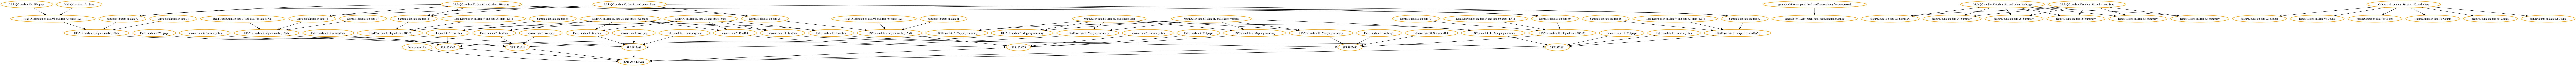

In [99]:
G = pgv.AGraph(directed=True)

for s, p, o in graph.triples((None, PROV.wasDerivedFrom, None)):
    d1 = get_short_label(str(o))
    d2 = get_short_label(str(s))
    G.add_node(d1, shape="ellipse", style="bold", color="orange")
    G.add_node(d2, shape="ellipse", style="bold", color="orange")
    G.add_edge(d2, d1)

display(Image(G.draw(format="png", prog="dot")))

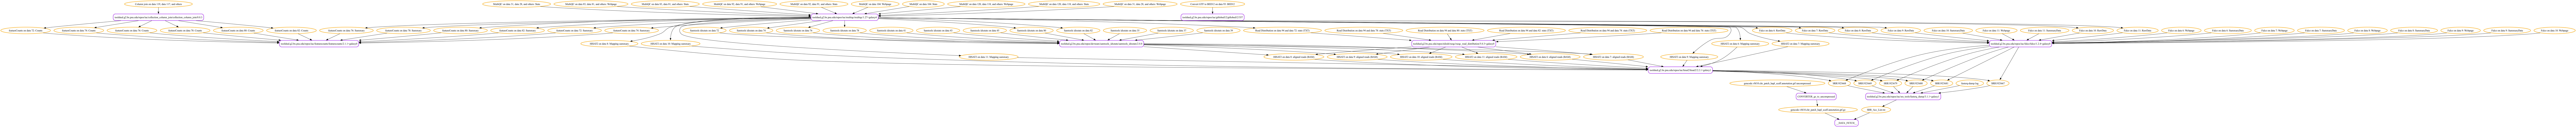

In [100]:
G = pgv.AGraph(directed=True)

for s, p, o in graph.triples((None, PROV.used, None)):
    tool = get_associated_tool(str(s))
    data = get_short_label(str(o))
    G.add_node(data, shape="ellipse", style="bold", color="orange")
    G.add_node(tool, shape="box", style="rounded, bold", color="purple")
    G.add_edge(tool, data)

for s, p, o in graph.triples((None, PROV.wasGeneratedBy, None)):
    tool = get_associated_tool(str(o))
    data = get_short_label(str(s))
    G.add_node(tool, shape="box", style="rounded, bold", color="purple")
    G.add_node(data, shape="ellipse", style="bold", color="orange")
    G.add_edge(data, tool)

display(Image(G.draw(format="png", prog="dot")))